MIEL-HAR Training
Device: cuda

Model Statistics:
  Parameters: 0.14 M
  FLOPs: 31.69 M
  Inference Time: 1.92 ms
  Physics m: 1.0000
  Physics I: 1.0000

Training for 100 epochs...
--------------------------------------------------------------------------------
Epoch    LR         Loss       Acc        F1         Prec       Rec       
--------------------------------------------------------------------------------
1        0.001000   1.2379     0.6837     0.6618     0.7130     0.6653     (*)
2        0.000999   0.8379     0.7682     0.7593     0.7713     0.7674     (*)
3        0.000998   0.7037     0.8035     0.7986     0.8246     0.7979     (*)
4        0.000996   0.6197     0.8541     0.8519     0.8571     0.8531     (*)
5        0.000994   0.5656     0.8843     0.8833     0.8883     0.8870     (*)
6        0.000991   0.5439     0.9023     0.9015     0.9013     0.9037     (*)
7        0.000988   0.5315     0.9009     0.9004     0.9011     0.9029    
8        0.000984   0.5290     0

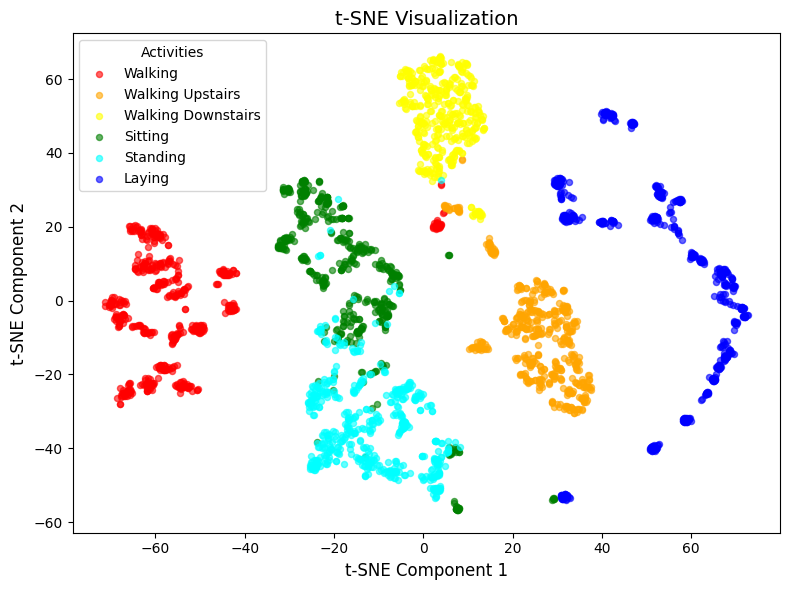

  t-SNE plot saved: MIEL_UCI_tsne.png


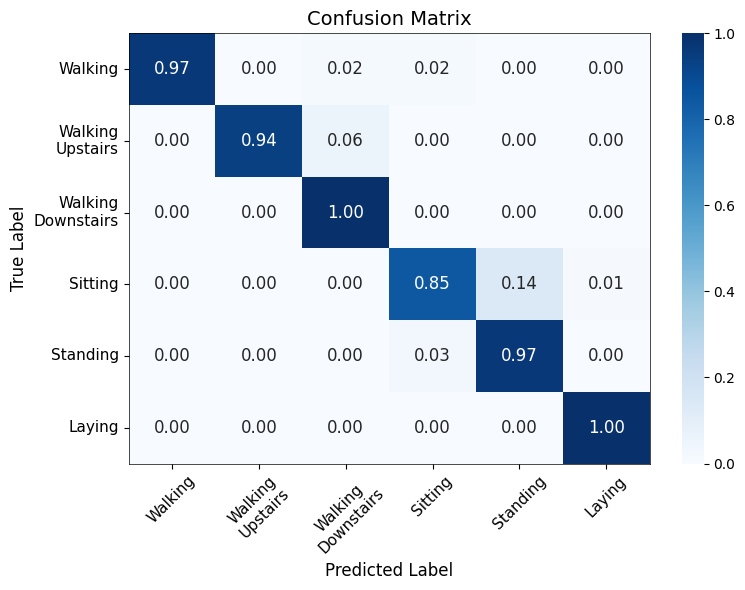

  Confusion matrix saved: MIEL_UCI_confusion.png

Training Complete!
  Params: 0.14M | FLOPs: 31.69M | Inf: 1.92ms
  Acc: 0.9528 | F1: 0.9526 | Prec: 0.9549 | Rec: 0.9529


In [1]:
!pip install thop ptflops
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from thop import profile
import time
import os


class UCIHARDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def read_txt_matrix(file_path):
    return np.loadtxt(file_path)


def load_split(root, split):
    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    channels = []
    for prefix in UCI_CHANNELS_PREFIX:
        file_path = os.path.join(root, f"{prefix}{split}.txt")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        channels.append(read_txt_matrix(file_path))
    X = np.stack(channels, axis=1)
    y = read_txt_matrix(os.path.join(root, f"y_{split}.txt")).astype(int) - 1
    subjects = read_txt_matrix(os.path.join(root, f"subject_{split}.txt")).astype(int)
    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    return X, y, subjects, activity_names


def load_uci_har(root_path='/content/drive/MyDrive/HAR_Dataset/UCI'):
    X_train, y_train, subjects_train, activity_names = load_split(root_path, 'train')
    X_test, y_test, subjects_test, _ = load_split(root_path, 'test')
    X_train = X_train.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)
    return X_train, y_train.astype(np.int64), X_test, y_test.astype(np.int64)


class RelativeEnergyPhysics(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.I = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):
        total_acc = x[:, :, 0:3]
        body_acc = x[:, :, 3:6]
        gyro = x[:, :, 6:9]

        m_pos = F.softplus(self.m)
        I_pos = F.softplus(self.I)

        acc_magnitude = (body_acc ** 2).sum(dim=-1, keepdim=True)
        E_kinetic_proxy = 0.5 * m_pos * acc_magnitude

        gyro_magnitude = (gyro ** 2).sum(dim=-1, keepdim=True)
        E_rotational_proxy = 0.5 * I_pos * gyro_magnitude

        gravity = total_acc - body_acc
        gravity_work = (gravity * body_acc).sum(dim=-1, keepdim=True)
        E_potential_change = m_pos * gravity_work

        E_relative = E_kinetic_proxy + E_rotational_proxy + E_potential_change

        return E_relative


class PotentialEnergyField(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128):
        super().__init__()
        self.physics = RelativeEnergyPhysics()
        self.energy_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        E_physics = self.physics(x)
        x_augmented = torch.cat([x, E_physics], dim=-1)
        E_learned = self.energy_net(x_augmented)
        return E_learned


class EnergyGradientFlow(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128):
        super().__init__()
        self.physics = RelativeEnergyPhysics()
        self.gradient_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        E_physics = self.physics(x)
        x_augmented = torch.cat([x, E_physics], dim=-1)
        gradient = self.gradient_net(x_augmented)

        body_acc = x[:, :, 0:3]
        gyro = x[:, :, 3:6]

        force_proxy = body_acc * F.softplus(self.physics.m)
        torque_proxy = gyro * F.softplus(self.physics.I)
        physics_gradient = torch.cat([force_proxy, torque_proxy, torch.zeros_like(body_acc)], dim=-1)

        return gradient + 0.1 * physics_gradient


class LandscapeGeometryEncoder(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=256):
        super().__init__()
        combined_dim = input_dim * 2 + 1
        self.input_proj = nn.Conv1d(combined_dim, hidden_dim, kernel_size=1)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8, batch_first=True)

    def forward(self, energy, gradient, x_original):
        landscape_state = torch.cat([x_original, gradient, energy], dim=-1)
        x = self.input_proj(landscape_state.transpose(1, 2))
        x = self.conv(x)
        x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        x = F.gelu(x)
        x = self.dropout(x)
        h_attn_in = x.transpose(1, 2)
        h_attn_out, _ = self.attention(h_attn_in, h_attn_in, h_attn_in)
        return h_attn_out


class MIELHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=256, num_classes=6):
        super().__init__()
        self.potential_field = PotentialEnergyField(input_dim, hidden_dim)
        self.gradient_flow = EnergyGradientFlow(input_dim, hidden_dim)
        self.landscape_encoder = LandscapeGeometryEncoder(input_dim, hidden_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        self.energy_reg_weight = 0.01

    def forward(self, x, return_energy=False):
        energy = self.potential_field(x)
        gradient = self.gradient_flow(x)
        landscape_features = self.landscape_encoder(energy, gradient, x)
        global_features = self.global_pool(landscape_features.transpose(1, 2)).squeeze(-1)
        logits = self.classifier(global_features)

        if return_energy:
            return logits, energy, gradient
        return logits

    def extract_features(self, x):
        energy = self.potential_field(x)
        gradient = self.gradient_flow(x)
        landscape_features = self.landscape_encoder(energy, gradient, x)
        global_features = self.global_pool(landscape_features.transpose(1, 2)).squeeze(-1)
        return global_features

    def compute_energy_loss(self, energy, gradient, labels):
        energy_diff = energy[:, 1:] - energy[:, :-1]
        smoothness_loss = torch.mean(energy_diff ** 2)
        gradient_mag = torch.norm(gradient, dim=-1)
        gradient_loss = torch.mean(gradient_mag)
        return smoothness_loss + 0.1 * gradient_loss


def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits, energy, gradient = model(batch_x, return_energy=True)
        cls_loss = F.cross_entropy(logits, batch_y)
        energy_loss = model.compute_energy_loss(energy, gradient, batch_y)
        loss = cls_loss + model.energy_reg_weight * energy_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    return total_loss / len(train_loader), accuracy_score(all_labels, all_preds)


def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, f1, precision, recall, cm


def extract_all_features(model, data_loader, device):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            features = model.extract_features(batch_x)
            all_features.append(features.cpu().numpy())
            all_labels.append(batch_y.numpy())
    return np.vstack(all_features), np.concatenate(all_labels)


def plot_tsne(features, labels, activity_names, save_path, samples_per_class=600):
    sampled_features, sampled_labels = [], []
    for i in range(len(activity_names)):
        class_mask = (labels == i)
        class_indices = np.where(class_mask)[0]
        if len(class_indices) > 0:
            if len(class_indices) >= samples_per_class:
                selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
            else:
                selected_indices = class_indices
            sampled_features.append(features[selected_indices])
            sampled_labels.append(labels[selected_indices])

    features_sampled = np.vstack(sampled_features)
    labels_sampled = np.concatenate(sampled_labels)

    n_samples = features_sampled.shape[0]
    perplexity = min(30, n_samples - 1)

    features_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, random_state=42).fit_transform(features_sampled)

    colors = ["#FF0000", "#FFA500", "#FFFF00", "#008000", "#00FFFF", "#0000FF"]

    plt.figure(figsize=(8, 6))
    for i, activity in enumerate(activity_names):
        mask = (labels_sampled == i)
        if np.any(mask):
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       color=colors[i], marker='o', s=19, alpha=0.6, label=activity)

    plt.legend(title="Activities", fontsize=10)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.title("t-SNE Visualization", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_confusion_matrix(cm, activity_names, save_path):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    labels = ['Walking', 'Walking\nUpstairs', 'Walking\nDownstairs', 'Sitting', 'Standing', 'Laying']

    df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

    annot = df.copy().astype(str)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            v = df.iloc[i, j]
            annot.iloc[i, j] = f"{v:.2f}"

    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=annot.values, fmt="", cmap="Blues", cbar=True,
                annot_kws={"size": 12}, vmin=0, vmax=1)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(rotation=0, fontsize=11)

    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor('black')

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def compute_flops_params(model, input_shape=(128, 9), device='cuda'):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops_m = macs * 2 / 1e6
    params_m = params / 1e6
    return flops_m, params_m


def measure_inference_time(model, input_shape=(128, 9), device='cuda', n_runs=100, warmup=10):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)

    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)

    if device == 'cuda':
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy_input)

    if device == 'cuda':
        torch.cuda.synchronize()

    end = time.time()
    return (end - start) / n_runs * 1000


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DATA_ROOT = '/content/drive/MyDrive/HAR_Dataset/UCI'

    print("=" * 80)
    print("MIEL-HAR Training")
    print("=" * 80)
    print(f"Device: {device}\n")

    try:
        X_train, y_train, X_test, y_test = load_uci_har(DATA_ROOT)
        activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

        train_dataset = UCIHARDataset(X_train, y_train)
        test_dataset = UCIHARDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

        model = MIELHAR(input_dim=9, hidden_dim=128, num_classes=6).to(device)

        flops_m, params_m = compute_flops_params(model, device=device)
        inf_time = measure_inference_time(model, device=device)

        print(f"Model Statistics:")
        print(f"  Parameters: {params_m:.2f} M")
        print(f"  FLOPs: {flops_m:.2f} M")
        print(f"  Inference Time: {inf_time:.2f} ms")
        print(f"  Physics m: {model.potential_field.physics.m.item():.4f}")
        print(f"  Physics I: {model.potential_field.physics.I.item():.4f}")
        print()

        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        NUM_EPOCHS = 100
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        best_acc = 0.0
        best_model_state = None
        best_metrics = {}

        print(f"Training for {NUM_EPOCHS} epochs...")
        print("-" * 80)
        print(f"{'Epoch':<8} {'LR':<10} {'Loss':<10} {'Acc':<10} {'F1':<10} {'Prec':<10} {'Rec':<10}")
        print("-" * 80)

        for epoch in range(NUM_EPOCHS):
            model.train()
            total_loss = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                logits, energy, gradient = model(batch_x, return_energy=True)
                cls_loss = criterion(logits, batch_y)
                energy_loss = model.compute_energy_loss(energy, gradient, batch_y)
                loss = cls_loss + model.energy_reg_weight * energy_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()
            test_acc, test_f1, test_prec, test_rec, cm = evaluate(model, test_loader, device)

            if test_acc > best_acc:
                best_acc = test_acc
                best_model_state = model.state_dict()
                best_metrics = {
                    'acc': test_acc,
                    'f1': test_f1,
                    'prec': test_prec,
                    'rec': test_rec,
                    'cm': cm
                }
                best_msg = " (*)"
            else:
                best_msg = ""

            current_lr = optimizer.param_groups[0]['lr']

            print(f"{epoch+1:<8} {current_lr:<10.6f} {total_loss/len(train_loader):<10.4f} "
                  f"{test_acc:<10.4f} {test_f1:<10.4f} {test_prec:<10.4f} {test_rec:<10.4f}{best_msg}")

        print("-" * 80)

        model.load_state_dict(best_model_state)

        print(f"\nFinal Results (Best Model):")
        print(f"  Accuracy: {best_metrics['acc']:.4f}")
        print(f"  F1 Score: {best_metrics['f1']:.4f}")
        print(f"  Precision: {best_metrics['prec']:.4f}")
        print(f"  Recall: {best_metrics['rec']:.4f}")
        print(f"  Learned m: {F.softplus(model.potential_field.physics.m).item():.4f}")
        print(f"  Learned I: {F.softplus(model.potential_field.physics.I).item():.4f}")
        print()

        print("Generating visualizations from best model...")
        features, labels = extract_all_features(model, test_loader, device)
        plot_tsne(features, labels, activity_names, 'MIEL_UCI_tsne.png')
        print("  t-SNE plot saved: MIEL_UCI_tsne.png")

        plot_confusion_matrix(best_metrics['cm'], activity_names, 'MIEL_UCI_confusion.png')
        print("  Confusion matrix saved: MIEL_UCI_confusion.png")

        print("\n" + "=" * 80)
        print(f"Training Complete!")
        print(f"  Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms")
        print(f"  Acc: {best_metrics['acc']:.4f} | F1: {best_metrics['f1']:.4f} | Prec: {best_metrics['prec']:.4f} | Rec: {best_metrics['rec']:.4f}")
        print("=" * 80)

    except Exception as e:
        import traceback
        traceback.print_exc()

MIEL-HAR Multi-Dataset Training
Device: cuda

Loading All Datasets

############################################################
Loading UCI-HAR...
############################################################
Train: (7352, 128, 9) | Classes: 6
Test: (2947, 128, 9) | Classes: 6
Activity Names: ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
Train class distribution: {np.int64(0): 1226, np.int64(1): 1073, np.int64(2): 986, np.int64(3): 1286, np.int64(4): 1374, np.int64(5): 1407}
Test class distribution: {np.int64(0): 496, np.int64(1): 471, np.int64(2): 420, np.int64(3): 491, np.int64(4): 532, np.int64(5): 537}

############################################################
Loading WISDM...
############################################################
Train: (19030, 80, 3) | Classes: 6
Test: (8156, 80, 3) | Classes: 6
Activity Names: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
Train class distribution: {np.int64(0): 1724, np.

/tmp/ipython-input-2766869385.py:624: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


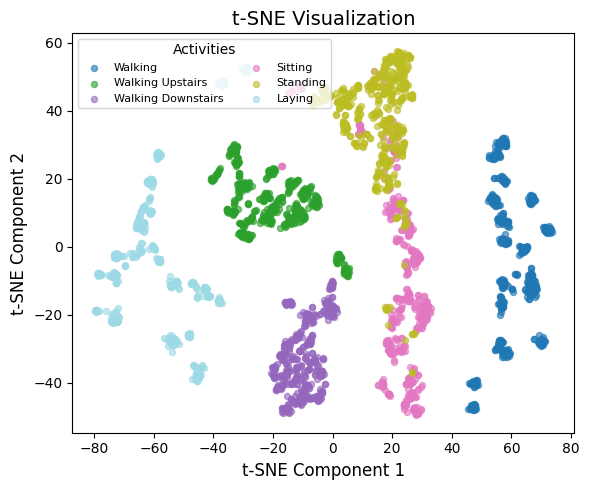

Generating Confusion Matrix for UCI-HAR...


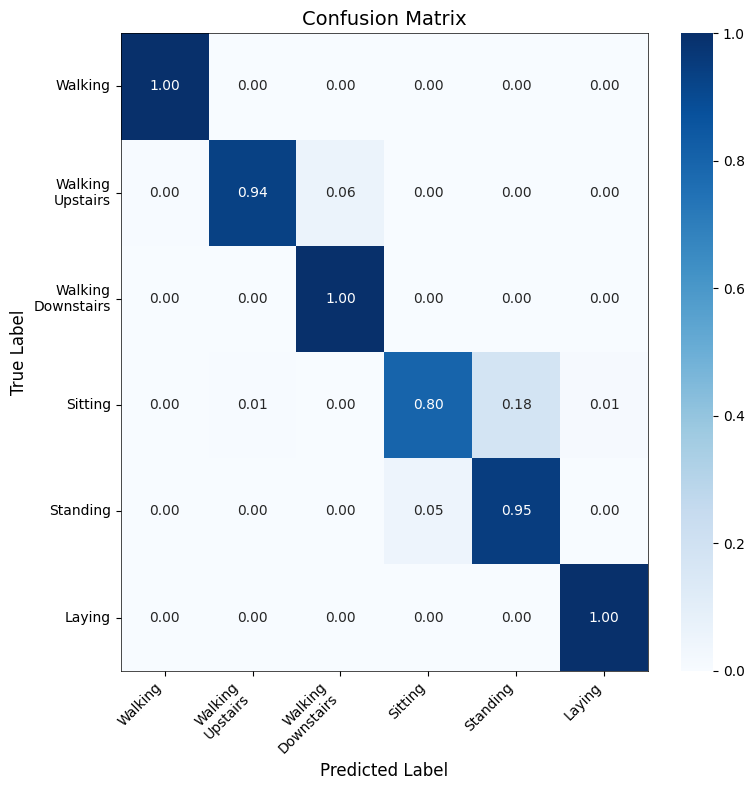


Training WISDM
Params: 0.14M | FLOPs: 19.20M | Inf: 2.01ms
Input: (80, 3) | Classes: 6
Acc indices: [0, 1, 2]
Gyro indices: []
Epoch    LR         Loss       Acc        F1         Prec       Rec       
------------------------------------------------------------
1        0.001000   1.0205     0.8272     0.7311     0.8011     0.7262     (*)
2        0.000999   0.6950     0.9174     0.8869     0.8881     0.8879     (*)
3        0.000998   0.5883     0.9426     0.9140     0.9240     0.9118     (*)
4        0.000996   0.5497     0.9567     0.9355     0.9416     0.9316     (*)
5        0.000994   0.5277     0.9572     0.9367     0.9509     0.9275     (*)
6        0.000991   0.5150     0.9719     0.9601     0.9635     0.9586     (*)
7        0.000988   0.5001     0.9785     0.9689     0.9688     0.9698     (*)
8        0.000984   0.4926     0.9800     0.9719     0.9695     0.9750     (*)
9        0.000980   0.4906     0.9828     0.9752     0.9753     0.9751     (*)
10       0.000976   0.477

/tmp/ipython-input-2766869385.py:624: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


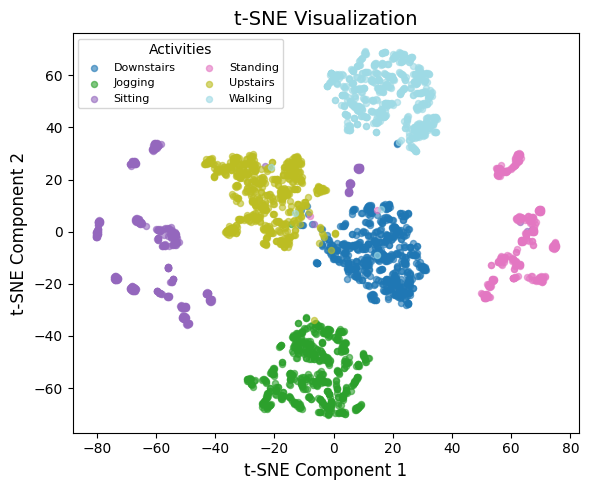

Generating Confusion Matrix for WISDM...


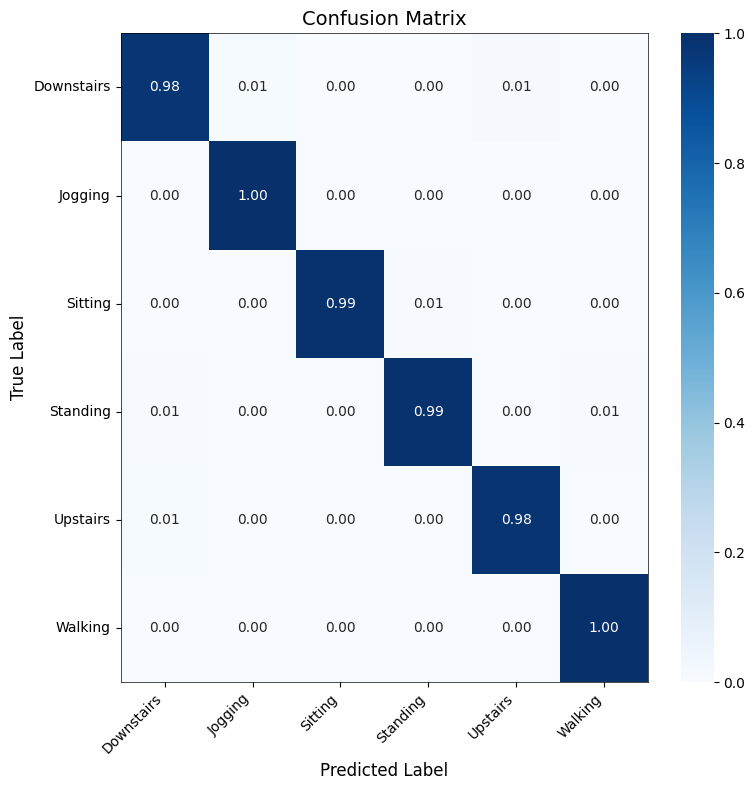


Training OPPORTUNITY
Params: 0.16M | FLOPs: 8.26M | Inf: 2.26ms
Input: (30, 30) | Classes: 17
Acc indices: [0, 1, 2, 6, 7, 8, 12, 13, 14, 18, 19, 20, 24, 25, 26]
Gyro indices: [3, 4, 5, 9, 10, 11, 15, 16, 17, 21, 22, 23, 27, 28, 29]
Epoch    LR         Loss       Acc        F1         Prec       Rec       
------------------------------------------------------------
1        0.001000   1.9121     0.6528     0.5610     0.6048     0.5614     (*)
2        0.000999   1.3829     0.7515     0.6842     0.7068     0.6853     (*)
3        0.000998   1.1704     0.7973     0.7414     0.7565     0.7443     (*)
4        0.000996   1.0489     0.8322     0.7876     0.7985     0.7871     (*)
5        0.000994   0.9638     0.8511     0.8130     0.8219     0.8114     (*)
6        0.000991   0.9008     0.8726     0.8393     0.8451     0.8362     (*)
7        0.000988   0.8739     0.8739     0.8363     0.8492     0.8364     (*)
8        0.000984   0.8367     0.8826     0.8556     0.8634     0.8519     (*

/tmp/ipython-input-2766869385.py:624: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


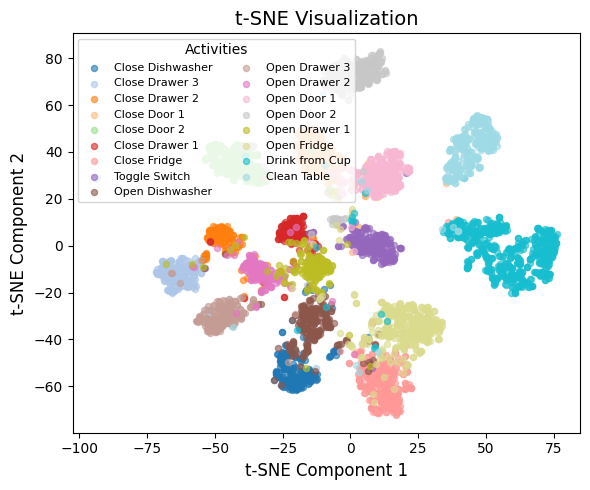

Generating Confusion Matrix for OPPORTUNITY...


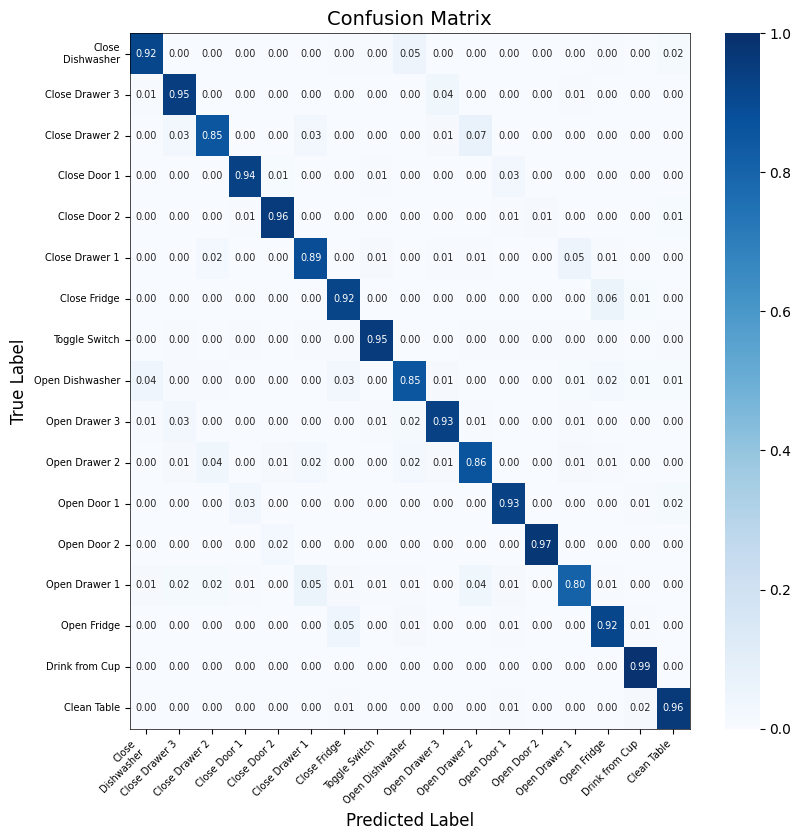


Training DSADS
Params: 0.17M | FLOPs: 7.37M | Inf: 2.30ms
Input: (25, 45) | Classes: 19
Acc indices: [0, 1, 2, 9, 10, 11, 18, 19, 20, 27, 28, 29, 36, 37, 38]
Gyro indices: [3, 4, 5, 12, 13, 14, 21, 22, 23, 30, 31, 32, 39, 40, 41]
Epoch    LR         Loss       Acc        F1         Prec       Rec       
------------------------------------------------------------
1        0.001000   1.6966     0.9391     0.9380     0.9420     0.9392     (*)
2        0.000999   0.8445     0.9759     0.9755     0.9778     0.9759     (*)
3        0.000998   0.6867     0.9900     0.9900     0.9900     0.9900     (*)
4        0.000996   0.6520     0.9951     0.9951     0.9952     0.9951     (*)
5        0.000994   0.6424     0.9945     0.9945     0.9946     0.9945    
6        0.000991   0.6336     0.9960     0.9960     0.9960     0.9960     (*)
7        0.000988   0.6280     0.9969     0.9969     0.9969     0.9969     (*)
8        0.000984   0.6234     0.9978     0.9978     0.9978     0.9978     (*)
9    

/tmp/ipython-input-2766869385.py:624: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


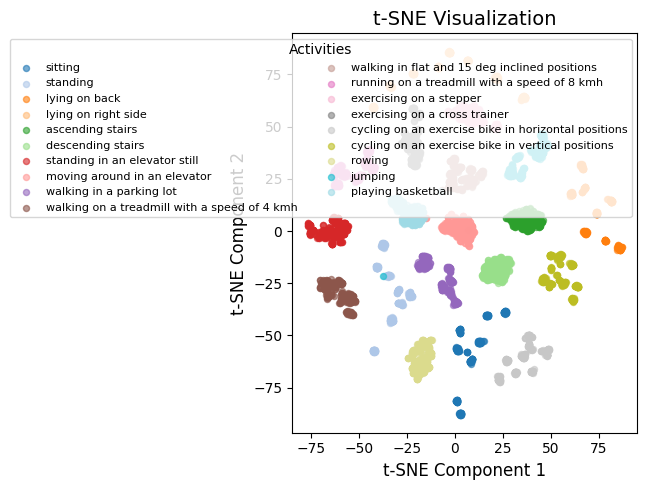

Generating Confusion Matrix for DSADS...


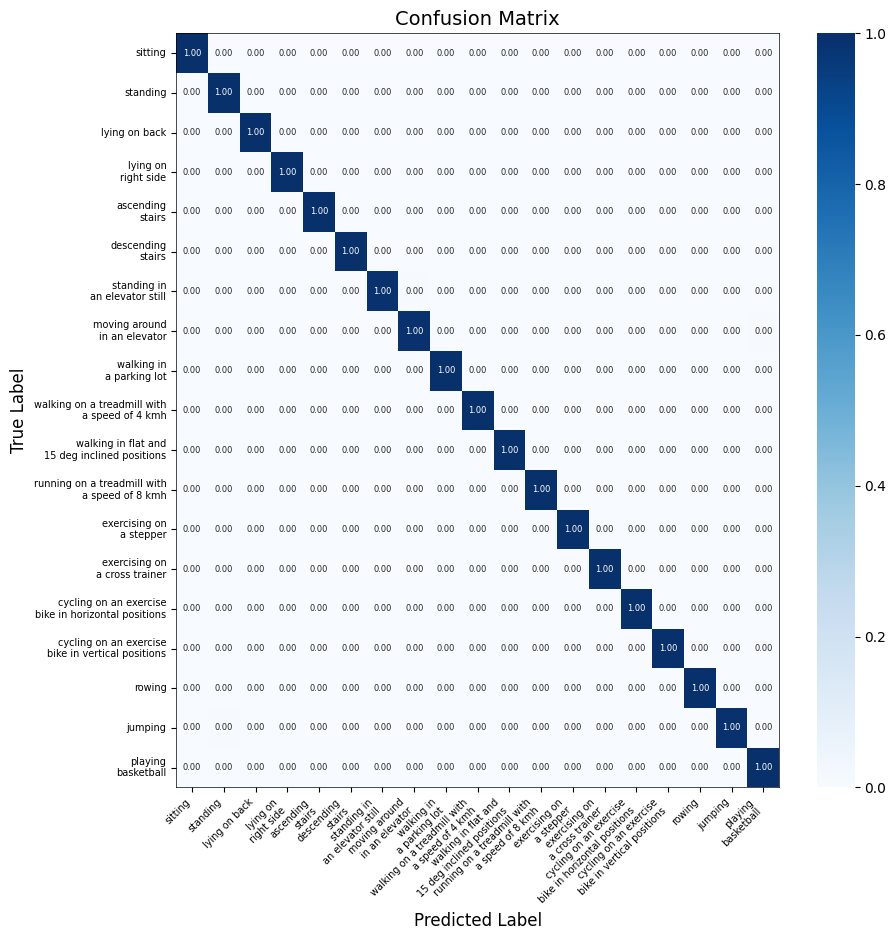


Training PAMAP2
Params: 0.15M | FLOPs: 25.92M | Inf: 3.11ms
Input: (100, 18) | Classes: 12
Acc indices: [0, 1, 2, 6, 7, 8, 12, 13, 14]
Gyro indices: [3, 4, 5, 9, 10, 11, 15, 16, 17]
Epoch    LR         Loss       Acc        F1         Prec       Rec       
------------------------------------------------------------
1        0.001000   1.1747     0.8860     0.8838     0.9071     0.8693     (*)
2        0.000999   0.8392     0.9069     0.9046     0.9172     0.8959     (*)
3        0.000998   0.7959     0.9198     0.9185     0.9283     0.9111     (*)
4        0.000996   0.7666     0.9226     0.9235     0.9391     0.9129     (*)
5        0.000994   0.7515     0.9245     0.9254     0.9413     0.9140     (*)
6        0.000991   0.7328     0.9320     0.9305     0.9416     0.9220     (*)
7        0.000988   0.7243     0.9338     0.9318     0.9413     0.9244     (*)
8        0.000984   0.7101     0.9334     0.9302     0.9346     0.9277    
9        0.000980   0.6970     0.9305     0.9305     

/tmp/ipython-input-2766869385.py:624: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


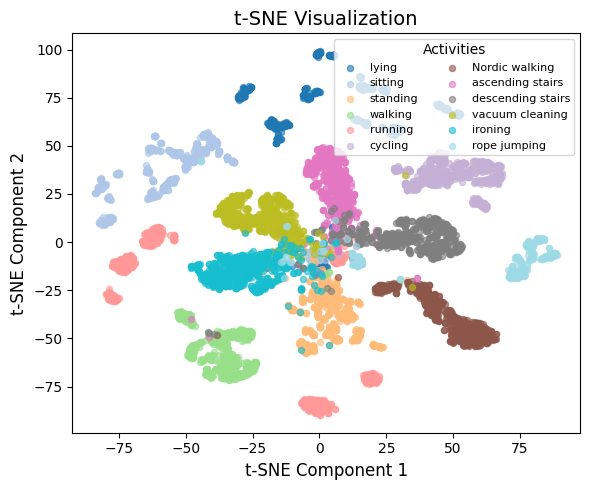

Generating Confusion Matrix for PAMAP2...


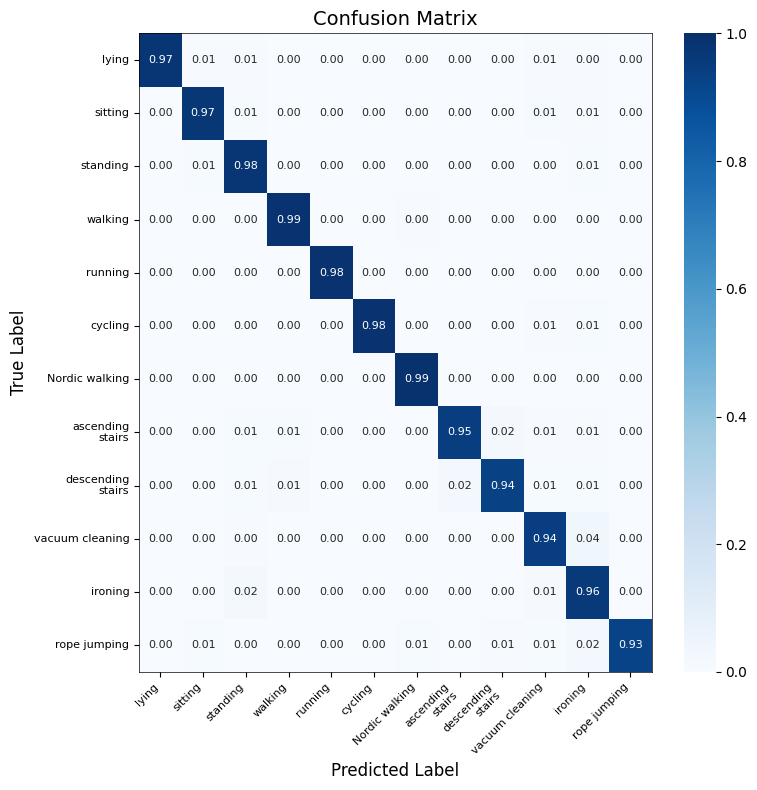


Training MHEALTH
Params: 0.15M | FLOPs: 13.17M | Inf: 2.82ms
Input: (50, 21) | Classes: 12
Acc indices: [0, 1, 2, 9, 10, 11]
Gyro indices: [6, 7, 8, 15, 16, 17]
Epoch    LR         Loss       Acc        F1         Prec       Rec       
------------------------------------------------------------
1        0.001000   1.3633     0.9283     0.9185     0.9349     0.9118     (*)
2        0.000999   0.7072     0.9849     0.9854     0.9853     0.9856     (*)
3        0.000998   0.6008     0.9942     0.9944     0.9945     0.9944     (*)
4        0.000996   0.5781     0.9947     0.9947     0.9945     0.9950     (*)
5        0.000994   0.5679     0.9954     0.9954     0.9952     0.9956     (*)
6        0.000991   0.5613     0.9973     0.9972     0.9970     0.9975     (*)
7        0.000988   0.5569     0.9959     0.9959     0.9957     0.9961    
8        0.000984   0.5542     0.9966     0.9968     0.9968     0.9967    
9        0.000980   0.5522     0.9964     0.9963     0.9961     0.9965    
10 

/tmp/ipython-input-2766869385.py:624: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


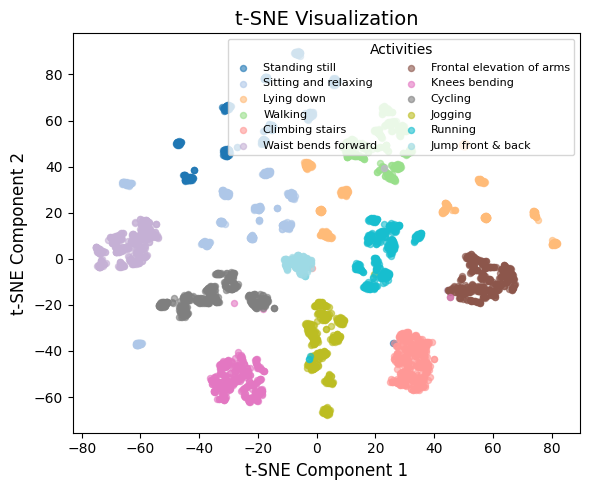

Generating Confusion Matrix for MHEALTH...


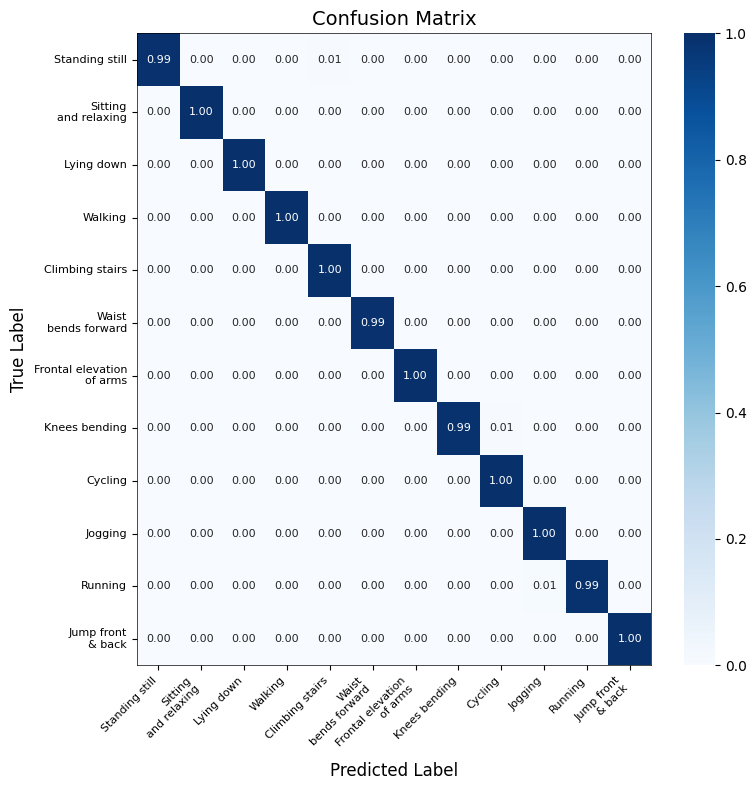


FINAL RESULTS - ALL DATASETS

    Dataset  Params(M)  FLOPs(M)  Inf(ms)    Acc     F1   Prec    Rec
    UCI-HAR       0.14     31.69     2.39 0.9535 0.9535 0.9552 0.9538
      WISDM       0.14     19.20     2.01 0.9937 0.9903 0.9907 0.9899
OPPORTUNITY       0.16      8.26     2.26 0.9367 0.9200 0.9220 0.9187
      DSADS       0.17      7.37     2.30 0.9993 0.9993 0.9993 0.9993
     PAMAP2       0.15     25.92     3.11 0.9692 0.9686 0.9718 0.9656
    MHEALTH       0.15     13.17     2.82 0.9973 0.9972 0.9970 0.9975



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from thop import profile
from collections import Counter
from glob import glob
import time
import os


class UCIHARDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def read_txt_matrix(file_path):
    return np.loadtxt(file_path)


def load_uci_har(root_path='/content/drive/MyDrive/HAR_Dataset/UCI'):
    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    def load_split(split):
        channels = []
        for prefix in UCI_CHANNELS_PREFIX:
            file_path = os.path.join(root_path, f"{prefix}{split}.txt")
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")
            channels.append(read_txt_matrix(file_path))
        X = np.stack(channels, axis=1)
        y = read_txt_matrix(os.path.join(root_path, f"y_{split}.txt")).astype(int) - 1
        return X, y
    X_train, y_train = load_split('train')
    X_test, y_test = load_split('test')
    X_train = X_train.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    scaler = StandardScaler()
    scaler.fit(X_train_flat)
    X_train_flat = scaler.transform(X_train_flat)
    X_test_flat = scaler.transform(X_test_flat)
    X_train = X_train_flat.reshape(X_train.shape)
    X_test = X_test_flat.reshape(X_test.shape)
    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    return X_train, y_train.astype(np.int64), X_test, y_test.astype(np.int64), activity_names


def load_wisdm_data(dataset_path="/content/drive/MyDrive/HAR_Dataset/WISDM"):
    if os.path.isfile(dataset_path):
        file_paths = [dataset_path]
    else:
        possible_files = ['WISDM_ar_v1.1_raw.txt', 'WISDM_ar_v1.1_trans.arff', 'wisdm-dataset.txt', 'actitracker_raw.txt']
        file_paths = []
        for filename in possible_files:
            full_path = os.path.join(dataset_path, filename)
            if os.path.exists(full_path):
                file_paths.append(full_path)
    if not file_paths:
        return None, None, None, None, None
    all_data = []
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        cleaned_data = []
        for line in lines:
            line = line.strip()
            if not line:
                continue
            line = line.rstrip(';').rstrip(',')
            if ',' in line:
                parts = line.split(',')
            elif ';' in line:
                parts = line.split(';')
            else:
                continue
            if len(parts) < 6:
                continue
            try:
                user = parts[0].strip()
                activity = parts[1].strip()
                timestamp = parts[2].strip()
                x_str = parts[3].strip()
                y_str = parts[4].strip()
                z_str = parts[5].strip()
                if ';' in x_str:
                    x_str = x_str.split(';')[0]
                if ';' in y_str:
                    y_str = y_str.split(';')[0]
                if ';' in z_str:
                    z_str = z_str.split(';')[0]
                x = float(x_str)
                y = float(y_str)
                z = float(z_str)
                cleaned_data.append([user, activity, timestamp, x, y, z])
            except (ValueError, IndexError):
                continue
        if cleaned_data:
            df = pd.DataFrame(cleaned_data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
            df['x'] = pd.to_numeric(df['x'], errors='coerce')
            df['y'] = pd.to_numeric(df['y'], errors='coerce')
            df['z'] = pd.to_numeric(df['z'], errors='coerce')
            df = df.dropna()
            all_data.append(df)
    if not all_data:
        return None, None, None, None, None
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df = combined_df.dropna()
    combined_df = combined_df[combined_df['activity'].str.strip() != '']
    all_windows = []
    all_labels = []
    groups = combined_df.groupby(['user', 'activity']) if 'user' in combined_df.columns else combined_df.groupby(['activity'])
    window_size = 80
    step = 40
    for group_name, group_data in groups:
        activity = group_name[-1] if isinstance(group_name, tuple) else group_name
        acc_data = group_data[['x', 'y', 'z']].values.astype(np.float32)
        if len(acc_data) < window_size:
            continue
        start = 0
        while start + window_size <= len(acc_data):
            window_data = acc_data[start:start + window_size, :]
            all_windows.append(window_data)
            all_labels.append(activity)
            start += step
    if not all_windows:
        return None, None, None, None, None
    X_windowed = np.array(all_windows, dtype=np.float32)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(all_labels)
    class_names = [str(label) for label in label_encoder.classes_]
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, class_names


def load_opportunity_local_data(data_path="/content/drive/MyDrive/HAR_Dataset/OPPORTUNITY", window_size=30, step=15):
    target_activities = {
        406516: 'Open Door 1', 406517: 'Open Door 2', 404516: 'Close Door 1', 404517: 'Close Door 2',
        406520: 'Open Fridge', 404520: 'Close Fridge', 406505: 'Open Dishwasher', 404505: 'Close Dishwasher',
        406519: 'Open Drawer 1', 404519: 'Close Drawer 1', 406511: 'Open Drawer 2', 404511: 'Close Drawer 2',
        406508: 'Open Drawer 3', 404508: 'Close Drawer 3', 408512: 'Clean Table', 407521: 'Drink from Cup',
        405506: 'Toggle Switch'
    }
    try:
        dat_files = glob(os.path.join(data_path, "**", "*.dat"), recursive=True)
        if not dat_files:
            return None, None, None, None, None
        all_data = []
        all_labels = []
        for file_path in dat_files:
            try:
                data = pd.read_csv(file_path, sep=r'\s+', header=None, na_values='NaN')
                if data.empty or data.shape[1] < 100:
                    continue
                data = data.ffill().bfill()
                imu_cols = [38, 39, 40, 41, 42, 43, 51, 52, 53, 54, 55, 56, 64, 65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 90, 91, 92, 93, 94, 95]
                features = data.iloc[:, imu_cols].values
                labels = data.iloc[:, 249].values
                valid_mask = (np.isfinite(features).all(axis=1) & np.isfinite(labels) & ~np.isnan(labels))
                features = features[valid_mask]
                labels = labels[valid_mask]
                target_mask = np.isin(labels, list(target_activities.keys()))
                if not np.any(target_mask):
                    continue
                features = features[target_mask]
                labels = labels[target_mask]
                all_data.append(features)
                all_labels.extend(labels)
            except:
                continue
        if not all_data:
            return None, None, None, None, None
        X_combined = np.vstack(all_data)
        y_combined = np.array(all_labels)
        unique_labels = np.unique(y_combined)
        label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        activity_labels = [target_activities.get(label, f"Class_{label}") for label in unique_labels]
        y_encoded = np.array([label_mapping[label] for label in y_combined])
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_combined)
        X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        all_windows = []
        all_window_labels = []
        start = 0
        while start + window_size <= len(X_scaled):
            window_data = X_scaled[start:start + window_size, :]
            window_label = y_encoded[start + window_size - 1]
            if np.isfinite(window_data).all():
                all_windows.append(window_data)
                all_window_labels.append(window_label)
            start += step
        if not all_windows:
            return None, None, None, None, None
        X_sequences = np.array(all_windows, dtype=np.float32)
        y_sequences = np.array(all_window_labels)
        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.3, stratify=y_sequences, random_state=42)
        return X_train, y_train, X_test, y_test, activity_labels
    except:
        return None, None, None, None, None


def load_dsads_data(data_path, w_s=25, stride=12):
    all_windows = []
    all_labels = []
    activities = {
        'a01': 'sitting', 'a02': 'standing', 'a03': 'lying on back',
        'a04': 'lying on right side', 'a05': 'ascending stairs',
        'a06': 'descending stairs', 'a07': 'standing in an elevator still',
        'a08': 'moving around in an elevator', 'a09': 'walking in a parking lot',
        'a10': 'walking on a treadmill with a speed of 4 kmh',
        'a11': 'walking in flat and 15 deg inclined positions',
        'a12': 'running on a treadmill with a speed of 8 kmh',
        'a13': 'exercising on a stepper', 'a14': 'exercising on a cross trainer',
        'a15': 'cycling on an exercise bike in horizontal positions',
        'a16': 'cycling on an exercise bike in vertical positions',
        'a17': 'rowing', 'a18': 'jumping', 'a19': 'playing basketball'
    }
    activity_codes = sorted(activities.keys())
    label_encoder = LabelEncoder()
    label_encoder.fit(activity_codes)
    persons = ['p' + str(i) for i in range(1, 9)]
    for person_str in persons:
        for activity_str in activity_codes:
            activity_label = label_encoder.transform([activity_str])[0]
            pattern = os.path.join(data_path, activity_str, person_str, 's*.txt')
            segment_files = sorted(glob(pattern))
            if not segment_files:
                continue
            for f in segment_files[:11]:
                try:
                    segment_data = np.loadtxt(f, delimiter=',')
                    if segment_data.shape[0] < w_s or segment_data.shape[1] < 45:
                        continue
                    segment_data = np.nan_to_num(segment_data, nan=0.0)
                    start = 0
                    while start + w_s <= segment_data.shape[0]:
                        window_data = segment_data[start : start + w_s, :]
                        all_windows.append(window_data)
                        all_labels.append(activity_label)
                        start += stride
                except:
                    continue
    if not all_windows:
        return None, None, None, None, None
    X_windowed = np.array(all_windows, dtype=np.float32)
    y_encoded = np.array(all_labels, dtype=int)
    scaler = StandardScaler()
    X_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_flat = scaler.fit_transform(X_flat)
    X_windowed = X_flat.reshape(X_windowed.shape)
    activity_names_sorted = [activities[code] for code in label_encoder.classes_]
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_names_sorted


def load_pamap2_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/PAMAP2"):
    file_paths = sorted(glob(os.path.join(dataset_dir, 'Protocol', 'subject*.dat')))
    optional_path = os.path.join(dataset_dir, 'Optional')
    if os.path.exists(optional_path):
        file_paths += sorted(glob(os.path.join(optional_path, 'subject*.dat')))
    if not file_paths:
        return None, None, None, None, None
    activity_labels = [
        "lying", "sitting", "standing", "walking", "running", "cycling",
        "Nordic walking", "ascending stairs", "descending stairs",
        "vacuum cleaning", "ironing", "rope jumping"
    ]
    label_to_activity_idx = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }
    all_windows = []
    all_labels = []
    window_size = 100
    step = 50
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=r'\s+', header=None, na_values='NaN')
        except:
            continue
        df_cleaned = df.ffill().bfill()
        if df_cleaned.empty:
            continue
        labels = df_cleaned.iloc[:, 1].values.astype(int)
        all_sensor_cols = list(range(4, 10)) + list(range(21, 27)) + list(range(38, 44))
        if df_cleaned.shape[1] < max(all_sensor_cols) + 1:
            continue
        features = df_cleaned.iloc[:, all_sensor_cols].values.astype(np.float32)
        valid_indices = np.where(np.isin(labels, list(label_to_activity_idx.keys())))[0]
        if len(valid_indices) == 0:
            continue
        features = features[valid_indices, :]
        labels = labels[valid_indices]
        if len(features) < window_size:
            continue
        start = 0
        while start + window_size <= len(features):
            window_data = features[start : start + window_size, :]
            window_labels_raw = labels[start : start + window_size]
            most_common_label = Counter(window_labels_raw).most_common(1)[0][0]
            if most_common_label in label_to_activity_idx:
                all_windows.append(window_data)
                all_labels.append(label_to_activity_idx[most_common_label])
            start += step
    if not all_windows:
        return None, None, None, None, None
    X_windowed = np.array(all_windows, dtype=np.float32)
    y_encoded = np.array(all_labels, dtype=int)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_labels


def load_mhealth_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/MHEALTH"):
    if not os.path.exists(dataset_dir):
        return None, None, None, None, None
    subject_files = sorted([
        os.path.join(dataset_dir, f)
        for f in os.listdir(dataset_dir)
        if f.startswith("mHealth_subject") and f.endswith(".log")
    ])
    if not subject_files:
        return None, None, None, None, None
    all_windows = []
    all_labels = []
    window_size = 50
    step = 25
    for file_path in subject_files:
        try:
            df = pd.read_csv(file_path, sep=r'\s+', header=None, engine='python', dtype=np.float32)
            df = df.ffill().bfill()
            if df.shape[1] < 24:
                continue
            labels = df.iloc[:, 23].values.astype(int)
            imu_cols = [0, 1, 2] + list(range(5, 23))
            features = df.iloc[:, imu_cols].values
            valid_indices = np.where(labels != 0)[0]
            if len(valid_indices) == 0:
                continue
            features = features[valid_indices, :]
            labels = labels[valid_indices]
            if len(features) < window_size:
                continue
            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]
                window_labels_raw = labels[start : start + window_size]
                most_common_label = Counter(window_labels_raw).most_common(1)[0][0]
                all_windows.append(window_data)
                all_labels.append(most_common_label)
                start += step
        except:
            continue
    if not all_windows:
        return None, None, None, None, None
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(all_labels)
    X_windowed = np.array(all_windows, dtype=np.float32)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    mhealth_activity_mapping = {
        1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down', 4: 'Walking',
        5: 'Climbing stairs', 6: 'Waist bends forward', 7: 'Frontal elevation of arms',
        8: 'Knees bending', 9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
    }
    activity_labels = []
    class_names = list(label_encoder.classes_)
    for encoded_idx in range(len(class_names)):
        original_label = class_names[encoded_idx]
        activity_labels.append(mhealth_activity_mapping.get(original_label, f"Unknown_Activity_{original_label}"))
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_labels


SENSOR_CONFIG = {
    'UCI-HAR': {
        'acc_indices': [0, 1, 2, 3, 4, 5],
        'gyro_indices': [6, 7, 8]
    },
    'WISDM': {
        'acc_indices': [0, 1, 2],
        'gyro_indices': []
    },
    'OPPORTUNITY': {
        'acc_indices': [0, 1, 2, 6, 7, 8, 12, 13, 14, 18, 19, 20, 24, 25, 26],
        'gyro_indices': [3, 4, 5, 9, 10, 11, 15, 16, 17, 21, 22, 23, 27, 28, 29]
    },
    'DSADS': {
        'acc_indices': [0, 1, 2, 9, 10, 11, 18, 19, 20, 27, 28, 29, 36, 37, 38],
        'gyro_indices': [3, 4, 5, 12, 13, 14, 21, 22, 23, 30, 31, 32, 39, 40, 41]
    },
    'PAMAP2': {
        'acc_indices': [0, 1, 2, 6, 7, 8, 12, 13, 14],
        'gyro_indices': [3, 4, 5, 9, 10, 11, 15, 16, 17]
    },
    'MHEALTH': {
        'acc_indices': [0, 1, 2, 9, 10, 11],
        'gyro_indices': [6, 7, 8, 15, 16, 17]
    }
}


class RelativeEnergyPhysics(nn.Module):
    def __init__(self, acc_indices, gyro_indices):
        super().__init__()
        self.acc_indices = acc_indices
        self.gyro_indices = gyro_indices
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.I = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):
        m_pos = F.softplus(self.m)
        I_pos = F.softplus(self.I)

        if len(self.acc_indices) > 0:
            acc_data = x[:, :, self.acc_indices]
            n_acc_sensors = len(self.acc_indices) // 3
            if n_acc_sensors > 0:
                acc_reshaped = acc_data.view(x.shape[0], x.shape[1], n_acc_sensors, 3)
                acc_magnitude = (acc_reshaped ** 2).sum(dim=-1).mean(dim=-1, keepdim=True)
            else:
                acc_magnitude = torch.zeros(x.shape[0], x.shape[1], 1, device=x.device)
        else:
            acc_magnitude = torch.zeros(x.shape[0], x.shape[1], 1, device=x.device)

        E_kinetic_proxy = 0.5 * m_pos * acc_magnitude

        if len(self.gyro_indices) > 0:
            gyro_data = x[:, :, self.gyro_indices]
            n_gyro_sensors = len(self.gyro_indices) // 3
            if n_gyro_sensors > 0:
                gyro_reshaped = gyro_data.view(x.shape[0], x.shape[1], n_gyro_sensors, 3)
                gyro_magnitude = (gyro_reshaped ** 2).sum(dim=-1).mean(dim=-1, keepdim=True)
            else:
                gyro_magnitude = torch.zeros(x.shape[0], x.shape[1], 1, device=x.device)
        else:
            gyro_magnitude = torch.zeros(x.shape[0], x.shape[1], 1, device=x.device)

        E_rotational_proxy = 0.5 * I_pos * gyro_magnitude
        E_relative = E_kinetic_proxy + E_rotational_proxy

        return E_relative


class PotentialEnergyField(nn.Module):
    def __init__(self, input_dim, hidden_dim, sensor_config):
        super().__init__()
        self.physics = RelativeEnergyPhysics(
            acc_indices=sensor_config['acc_indices'],
            gyro_indices=sensor_config['gyro_indices']
        )
        self.energy_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        E_physics = self.physics(x)
        x_augmented = torch.cat([x, E_physics], dim=-1)
        E_learned = self.energy_net(x_augmented)
        return E_learned


class EnergyGradientFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, sensor_config):
        super().__init__()
        self.acc_indices = sensor_config['acc_indices']
        self.gyro_indices = sensor_config['gyro_indices']
        self.input_dim = input_dim
        self.physics = RelativeEnergyPhysics(
            acc_indices=sensor_config['acc_indices'],
            gyro_indices=sensor_config['gyro_indices']
        )
        self.gradient_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        E_physics = self.physics(x)
        x_augmented = torch.cat([x, E_physics], dim=-1)
        gradient = self.gradient_net(x_augmented)

        m_pos = F.softplus(self.physics.m)
        I_pos = F.softplus(self.physics.I)

        physics_gradient = torch.zeros_like(x)

        if len(self.acc_indices) > 0:
            acc_data = x[:, :, self.acc_indices]
            force_proxy = acc_data * m_pos
            physics_gradient[:, :, self.acc_indices] = force_proxy

        if len(self.gyro_indices) > 0:
            gyro_data = x[:, :, self.gyro_indices]
            torque_proxy = gyro_data * I_pos
            physics_gradient[:, :, self.gyro_indices] = torque_proxy

        return gradient + 0.1 * physics_gradient


class LandscapeGeometryEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        combined_dim = input_dim * 2 + 1
        self.input_proj = nn.Conv1d(combined_dim, hidden_dim, kernel_size=1)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8, batch_first=True)

    def forward(self, energy, gradient, x_original):
        landscape_state = torch.cat([x_original, gradient, energy], dim=-1)
        x = self.input_proj(landscape_state.transpose(1, 2))
        x = self.conv(x)
        x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        x = F.gelu(x)
        x = self.dropout(x)
        h_attn_in = x.transpose(1, 2)
        h_attn_out, _ = self.attention(h_attn_in, h_attn_in, h_attn_in)
        return h_attn_out


class MIELHAR(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, sensor_config):
        super().__init__()
        self.potential_field = PotentialEnergyField(input_dim, hidden_dim, sensor_config)
        self.gradient_flow = EnergyGradientFlow(input_dim, hidden_dim, sensor_config)
        self.landscape_encoder = LandscapeGeometryEncoder(input_dim, hidden_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        self.energy_reg_weight = 0.01

    def forward(self, x, return_energy=False):
        energy = self.potential_field(x)
        gradient = self.gradient_flow(x)
        landscape_features = self.landscape_encoder(energy, gradient, x)
        global_features = self.global_pool(landscape_features.transpose(1, 2)).squeeze(-1)
        logits = self.classifier(global_features)
        if return_energy:
            return logits, energy, gradient
        return logits

    def extract_features(self, x):
        energy = self.potential_field(x)
        gradient = self.gradient_flow(x)
        landscape_features = self.landscape_encoder(energy, gradient, x)
        global_features = self.global_pool(landscape_features.transpose(1, 2)).squeeze(-1)
        return global_features

    def compute_energy_loss(self, energy, gradient, labels):
        energy_diff = energy[:, 1:] - energy[:, :-1]
        smoothness_loss = torch.mean(energy_diff ** 2)
        gradient_mag = torch.norm(gradient, dim=-1)
        gradient_loss = torch.mean(gradient_mag)
        return smoothness_loss + 0.1 * gradient_loss


def plot_tsne(features, labels, activity_names, save_path, samples_per_class=600):
    sampled_features, sampled_labels = [], []
    for i in range(len(activity_names)):
        class_mask = (labels == i)
        class_indices = np.where(class_mask)[0]
        if len(class_indices) > 0:
            if len(class_indices) >= samples_per_class:
                selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
            else:
                selected_indices = class_indices
            sampled_features.append(features[selected_indices])
            sampled_labels.append(labels[selected_indices])

    features_sampled = np.vstack(sampled_features)
    labels_sampled = np.concatenate(sampled_labels)

    n_samples = features_sampled.shape[0]
    perplexity = min(30, n_samples - 1)

    features_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, random_state=42).fit_transform(features_sampled)

    num_classes = len(activity_names)
    cmap = plt.cm.get_cmap('tab20', num_classes)
    colors = [cmap(i) for i in range(num_classes)]

    plt.figure(figsize=(6, 5))
    for i, activity in enumerate(activity_names):
        mask = (labels_sampled == i)
        if np.any(mask):
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       color=colors[i], marker='o', s=19, alpha=0.6, label=activity)

    plt.legend(title="Activities", fontsize=8, loc='best', ncol=2)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.title("t-SNE Visualization", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_confusion_matrix(cm, activity_names, save_path):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    num_classes = len(activity_names)
    labels = []
    for name in activity_names:
        if len(name) > 15:
            words = name.split()
            if len(words) > 1:
                mid = len(words) // 2
                labels.append(' '.join(words[:mid]) + '\n' + ' '.join(words[mid:]))
            else:
                labels.append(name[:15] + '\n' + name[15:])
        else:
            labels.append(name)

    df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

    annot = df.copy().astype(str)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            v = df.iloc[i, j]
            annot.iloc[i, j] = f"{v:.2f}"

    figsize = max(8, num_classes * 0.5)
    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(df, annot=annot.values, fmt="", cmap="Blues", cbar=True,
                annot_kws={"size": max(6, 12 - num_classes // 3)}, vmin=0, vmax=1)
    plt.xticks(rotation=45, ha='right', fontsize=max(6, 11 - num_classes // 4))
    plt.yticks(rotation=0, fontsize=max(6, 11 - num_classes // 4))

    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor('black')

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return acc, f1, precision, recall


def extract_features_and_predictions(model, data_loader, device):
    model.eval()
    all_features, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            features = model.extract_features(batch_x)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_features.append(features.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    return np.vstack(all_features), np.array(all_preds), np.array(all_labels)


def compute_flops_params(model, input_shape, device):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops_m = macs * 2 / 1e6
    params_m = params / 1e6
    return flops_m, params_m


def measure_inference_time(model, input_shape, device, n_runs=100, warmup=10):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)
    if device == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy_input)
    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / n_runs * 1000


def train_single_dataset(dataset_name, X_train, y_train, X_test, y_test, activity_names, device, epochs=100):
    seq_len = X_train.shape[1]
    input_dim = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    sensor_config = SENSOR_CONFIG[dataset_name]

    train_dataset = UCIHARDataset(X_train, y_train)
    test_dataset = UCIHARDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = MIELHAR(input_dim=input_dim, hidden_dim=128, num_classes=num_classes, sensor_config=sensor_config).to(device)

    flops_m, params_m = compute_flops_params(model, (seq_len, input_dim), device)
    inf_time = measure_inference_time(model, (seq_len, input_dim), device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    best_acc = 0.0
    best_metrics = {}
    best_model_state = None

    print(f"\n{'='*60}")
    print(f"Training {dataset_name}")
    print(f"{'='*60}")
    print(f"Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms")
    print(f"Input: ({seq_len}, {input_dim}) | Classes: {num_classes}")
    print(f"Acc indices: {sensor_config['acc_indices']}")
    print(f"Gyro indices: {sensor_config['gyro_indices']}")
    print(f"{'Epoch':<8} {'LR':<10} {'Loss':<10} {'Acc':<10} {'F1':<10} {'Prec':<10} {'Rec':<10}")
    print("-" * 60)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits, energy, gradient = model(batch_x, return_energy=True)
            cls_loss = criterion(logits, batch_y)
            energy_loss = model.compute_energy_loss(energy, gradient, batch_y)
            loss = cls_loss + model.energy_reg_weight * energy_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, device)

        if test_acc > best_acc:
            best_acc = test_acc
            best_metrics = {
                'acc': test_acc,
                'f1': test_f1,
                'prec': test_prec,
                'rec': test_rec
            }
            best_model_state = model.state_dict().copy()
            best_msg = " (*)"
        else:
            best_msg = ""

        current_lr = optimizer.param_groups[0]['lr']
        print(f"{epoch+1:<8} {current_lr:<10.6f} {total_loss/len(train_loader):<10.4f} "
              f"{test_acc:<10.4f} {test_f1:<10.4f} {test_prec:<10.4f} {test_rec:<10.4f}{best_msg}")

    print("-" * 60)
    print(f"Best - Acc: {best_metrics['acc']:.4f} | F1: {best_metrics['f1']:.4f} | Prec: {best_metrics['prec']:.4f} | Rec: {best_metrics['rec']:.4f}")
    print(f"Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms")

    model.load_state_dict(best_model_state)

    features, preds, labels = extract_features_and_predictions(model, test_loader, device)

    cm = confusion_matrix(labels, preds)

    tsne_path = f"{dataset_name}_tsne.png"
    cm_path = f"{dataset_name}_confusion_matrix.png"

    print(f"\nGenerating t-SNE plot for {dataset_name}...")
    plot_tsne(features, labels, activity_names, tsne_path)

    print(f"Generating Confusion Matrix for {dataset_name}...")
    plot_confusion_matrix(cm, activity_names, cm_path)

    return {
        'Dataset': dataset_name,
        'Params(M)': round(params_m, 2),
        'FLOPs(M)': round(flops_m, 2),
        'Inf(ms)': round(inf_time, 2),
        'Acc': round(best_metrics['acc'], 4),
        'F1': round(best_metrics['f1'], 4),
        'Prec': round(best_metrics['prec'], 4),
        'Rec': round(best_metrics['rec'], 4)
    }


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("=" * 80)
    print("MIEL-HAR Multi-Dataset Training")
    print("=" * 80)
    print(f"Device: {device}\n")

    datasets_config = [
        ('UCI-HAR', load_uci_har, '/content/drive/MyDrive/HAR_Dataset/UCI'),
        ('WISDM', load_wisdm_data, '/content/drive/MyDrive/HAR_Dataset/WISDM'),
        ('OPPORTUNITY', load_opportunity_local_data, '/content/drive/MyDrive/HAR_Dataset/OPPORTUNITY'),
        ('DSADS', load_dsads_data, '/content/drive/MyDrive/HAR_Dataset/DSADS'),
        ('PAMAP2', load_pamap2_data, '/content/drive/MyDrive/HAR_Dataset/PAMAP2'),
        ('MHEALTH', load_mhealth_data, '/content/drive/MyDrive/HAR_Dataset/MHEALTH')
    ]

    all_datasets = {}

    print("=" * 80)
    print("Loading All Datasets")
    print("=" * 80)

    for dataset_name, loader_func, data_path in datasets_config:
        try:
            print(f"\n{'#'*60}")
            print(f"Loading {dataset_name}...")
            print(f"{'#'*60}")

            data = loader_func(data_path)
            if data is None or data[0] is None:
                print(f"Failed to load {dataset_name}")
                continue

            X_train, y_train, X_test, y_test, activity_names = data

            num_train_classes = len(np.unique(y_train))
            num_test_classes = len(np.unique(y_test))

            print(f"Train: {X_train.shape} | Classes: {num_train_classes}")
            print(f"Test: {X_test.shape} | Classes: {num_test_classes}")
            print(f"Activity Names: {activity_names}")

            train_class_dist = Counter(y_train)
            test_class_dist = Counter(y_test)
            print(f"Train class distribution: {dict(sorted(train_class_dist.items()))}")
            print(f"Test class distribution: {dict(sorted(test_class_dist.items()))}")

            all_datasets[dataset_name] = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test,
                'activity_names': activity_names
            }

        except Exception as e:
            print(f"Error loading {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue

    print(f"\n{'='*80}")
    print(f"Successfully loaded {len(all_datasets)} datasets")
    print(f"{'='*80}\n")

    results = []

    for dataset_name, dataset_data in all_datasets.items():
        try:
            result = train_single_dataset(
                dataset_name,
                dataset_data['X_train'],
                dataset_data['y_train'],
                dataset_data['X_test'],
                dataset_data['y_test'],
                dataset_data['activity_names'],
                device,
                epochs=100
            )
            results.append(result)
        except Exception as e:
            print(f"Error training {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue

    if results:
        print(f"\n{'='*80}")
        print("FINAL RESULTS - ALL DATASETS")
        print(f"{'='*80}\n")
        results_df = pd.DataFrame(results)
        results_df = results_df[['Dataset', 'Params(M)', 'FLOPs(M)', 'Inf(ms)', 'Acc', 'F1', 'Prec', 'Rec']]
        print(results_df.to_string(index=False))
        print(f"\n{'='*80}")